# **Optimizing AUROC loss on imbalanced dataset**

**Author**: Zhuoning Yuan

**Introduction**

In this tutorial, you will learn how to quickly train a ResNet20 model by optimizing **AUROC** using our novel [AUCMLoss](https://arxiv.org/abs/2012.03173) and `PESG` optimizer on a binary image classification task on Cifar10. After completion of this tutorial, you should be able to use LibAUC to train your own models on your own datasets.


**Useful Resources**:
* Website: https://libauc.org
* Github: https://github.com/Optimization-AI/LibAUC

**Reference**:  

If you find this tutorial helpful in your work,  please acknowledge our library and cite the following paper:
<pre>
@inproceedings{yuan2021large,
  title={Large-scale robust deep auc maximization: A new surrogate loss and empirical studies on medical image classification},
  author={Yuan, Zhuoning and Yan, Yan and Sonka, Milan and Yang, Tianbao},
  booktitle={Proceedings of the IEEE/CVF International Conference on Computer Vision},
  pages={3040--3049},
  year={2021}
}
</pre>

## **Installing LibAUC**

Let's start with install our library here. In this tutorial, we will use version `1.2.0`.

In [ ]:
!pip install libauc==1.2.0

# **Importing LibAUC**
Import required libraries to use

In [2]:
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.models import resnet20 as ResNet20
from libauc.datasets import CIFAR10
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import auc_roc_score

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score

## **Reproducibility**

These functions limit the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [3]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## **Image Dataset**


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip`.




In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target

## **Introduction for Loss and Optimizer**

In this section, we will introduce how to utilize `AUCMLoss` function and `PESG` optimizer.  

#### **AUCMLoss**
The objective function for `AUCMLoss` is defined as

\begin{align} F(\mathbf{w},a,b,\alpha; \mathbf{z}) &=(1-p)(h_w(x)-a)^2\mathbf{I}_{[y=1]} +p(h_w(x)-b)^2\mathbf{I}_{[y=-1]} \\
&+2\alpha(p(1-p)m+ p h_w(x)\mathbf{I}_{[y=-1]}-(1-p)h_w(x)\mathbf{I}_{[y=1]})\\
&-p(1-p)\alpha^2
\end{align}

where $p$ is the ratio of positive samples to all samples in a mini-batch, $a$, $b$ are the running statistics of the positive and negative predictions, $\alpha$ is the auxiliary variable derived from the problem formulation. For the derivation of the above formulation, please refer to the paper [[ref]](https://arxiv.org/abs/2012.03173).

**PESG** is used for optimizing the AUC margin loss and the key update steps are sumarized as follow:
1. Initialize $\mathbf v_0= \mathbf v_{ref}=\{\mathbf{w_0}, a_0, b_0\}, \alpha_0\geq 0$
2. For $t=1, \ldots, T$:
3. $\hspace{0.2in}$ Compute $\nabla_{\mathbf v} F(\mathbf v_t, \alpha_t; z_t)$ and $\nabla_\alpha F(\mathbf v_t, \alpha_t; z_t)$.
4. $\hspace{0.2in}$ Update primal variables
$$
\mathbf v_{t+1} = \mathbf v_{t} - \eta (\nabla_{\mathbf v} F(\mathbf v_t, \alpha_t; z_t)+ \lambda_0 (\mathbf v_t-\mathbf v_{\text{ref}})) - \lambda \eta\mathbf v_t 
$$
5. $\hspace{0.2in}$ Update dual variable 
$$\alpha_{t+1}=  [\alpha_{t} + \eta \nabla_\alpha F(\mathbf v_t, \alpha_t; z_t)]_+$$
6.  $\hspace{0.2in}$ Decrease $\eta$ by a decay factor and update $\mathbf v_{\text{ref}}$ periodically 

where ${z_t}$ is the data pair $(x_t, y_t)$, $\lambda_0$ is the epoch-level l2 penaty (i.e., `epoch_decay`) and $\eta$ is the learning rate. For more details, please refer to the paper [[ref]](https://arxiv.org/abs/2012.03173).

## **Hyper-parameters**
**DualSampler**
- `batch_size`: how many samples per mini-batch used for training model 
- `sampling_rate`: the oversampling ratio for the positive minority class (default: 0.0)

**Loss**
  * `margin`: margin for surrogate loss (i.e., squred hinge loss). It is intergrated with optimizer (default: 1.0)
    
**Optimizer**
  * `lr`: learning rate
  * `momentum`: momentum factor (default: 0.9)
  * `weight_decay`: weight decay (L2 penalty) (default: 1e-5)
  * `epoch_decay`: epoch decay (L2 penalty for epoch-level regularization) (default: 2e-3)

## **Tips**
 - `sampling_ratio` can be tuned in (0, 0.5] based on different datasets
 - `epoch_decay` is a regularization parameter similar to `weight_decay` that can be tuned
 - `momentum` is similar to SGD-momentum and you can choose value in [0, 0.9]
 - `margin` can also be tuned in [0.5, 1.0] for better performance



# **Paramaters**

In [43]:
# HyperParameters
SEED = 123
BATCH_SIZE = 128
imratio = 0.1 # for demo 
total_epochs = 100
decay_epochs = [50, 75]

lr = 0.1
margin = 1.0
epoch_decay = 0.003 # refers gamma in the paper
weight_decay = 0.0001

# oversampling minority class, you can tune it in (0, 0.5]
# e.g., sampling_rate=0.2 is that num of positive samples in mini-batch is sampling_rate*batch_size=13
sampling_rate = 0.2 

# **Loading datasets**

In [44]:
# load data as numpy arrays 
train_data, train_targets = CIFAR10(root='./data', train=True)
test_data, test_targets  = CIFAR10(root='./data', train=False)

# generate imbalanced data
generator = ImbalancedDataGenerator(verbose=True, random_seed=0)
(train_images, train_labels) = generator.transform(train_data, train_targets, imratio=imratio)
(test_images, test_labels) = generator.transform(test_data, test_targets, imratio=0.5) 

# data augmentations 
trainSet = ImageDataset(train_images, train_labels)
trainSet_eval = ImageDataset(train_images, train_labels, mode='test')
testSet = ImageDataset(test_images, test_labels, mode='test')

# dataloaders
sampler = DualSampler(trainSet, BATCH_SIZE, sampling_rate=sampling_rate)
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
trainloader_eval = torch.utils.data.DataLoader(trainSet_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
#SAMPLES: [27777], POS:NEG: [2777 : 25000], POS RATIO: 0.1000
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


# **Creating models & AUC Optimizer**

In [45]:
# You can include sigmoid/l2 activations on model's outputs before computing loss
model = ResNet20(pretrained=False, last_activation=None, num_classes=1)
model = model.cuda()

# You can also pass Loss.a, Loss.b, Loss.alpha to optimizer (for old version users)
loss_fn = AUCMLoss()
optimizer = PESG(model, 
                 loss_fn=loss_fn,
                 lr=lr, 
                 momentum=0.9,
                 margin=margin, 
                 epoch_decay=epoch_decay, 
                 weight_decay=weight_decay)

# **Training**

In [46]:
print ('Start Training')
print ('-'*30)

train_log = []
test_log = []
for epoch in range(total_epochs):
     if epoch in decay_epochs:
         optimizer.update_regularizer(decay_factor=10) # decrease learning rate by 10x & update regularizer
   
     train_loss = []
     model.train()    
     for data, targets in trainloader:
         data, targets  = data.cuda(), targets.cuda()
         y_pred = model(data)
         y_pred = torch.sigmoid(y_pred)
         loss = loss_fn(y_pred, targets)
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         train_loss.append(loss.item())
    
     # evaluation on train & test sets
     model.eval()
     train_pred_list = []
     train_true_list = []
     for train_data, train_targets in trainloader_eval:
         train_data = train_data.cuda()
         train_pred = model(train_data)
         train_pred_list.append(train_pred.cpu().detach().numpy())
         train_true_list.append(train_targets.numpy())
     train_true = np.concatenate(train_true_list)
     train_pred = np.concatenate(train_pred_list)
     train_auc = auc_roc_score(train_true, train_pred)
     train_loss = np.mean(train_loss)
  
     test_pred_list = []
     test_true_list = [] 
     for test_data, test_targets in testloader:
         test_data = test_data.cuda()
         test_pred = model(test_data)
         test_pred_list.append(test_pred.cpu().detach().numpy())
         test_true_list.append(test_targets.numpy())
     test_true = np.concatenate(test_true_list)
     test_pred = np.concatenate(test_pred_list)
     val_auc =  auc_roc_score(test_true, test_pred) 
     model.train()
 
     # print results
     print("epoch: %s, train_loss: %.4f, train_auc: %.4f, test_auc: %.4f, lr: %.4f"%(epoch, train_loss, train_auc, val_auc, optimizer.lr ))    
     train_log.append(train_auc) 
     test_log.append(val_auc)     

Start Training
------------------------------
epoch: 0, train_loss: 0.1494, train_auc: 0.6466, test_auc: 0.6599, lr: 0.1000
epoch: 1, train_loss: 0.1321, train_auc: 0.6940, test_auc: 0.6875, lr: 0.1000
epoch: 2, train_loss: 0.1201, train_auc: 0.6966, test_auc: 0.6886, lr: 0.1000
epoch: 3, train_loss: 0.1129, train_auc: 0.7146, test_auc: 0.6921, lr: 0.1000
epoch: 4, train_loss: 0.1063, train_auc: 0.7244, test_auc: 0.7042, lr: 0.1000
epoch: 5, train_loss: 0.0999, train_auc: 0.7648, test_auc: 0.7498, lr: 0.1000
epoch: 6, train_loss: 0.0961, train_auc: 0.7872, test_auc: 0.7664, lr: 0.1000
epoch: 7, train_loss: 0.0902, train_auc: 0.7823, test_auc: 0.7479, lr: 0.1000
epoch: 8, train_loss: 0.0880, train_auc: 0.8169, test_auc: 0.7931, lr: 0.1000
epoch: 9, train_loss: 0.0835, train_auc: 0.8177, test_auc: 0.7858, lr: 0.1000
epoch: 10, train_loss: 0.0801, train_auc: 0.8201, test_auc: 0.7912, lr: 0.1000
epoch: 11, train_loss: 0.0789, train_auc: 0.8414, test_auc: 0.7987, lr: 0.1000
epoch: 12, train

# **Visualization**
Now, let's see the learning curve of optimizing AUROC on train and tes sets. 


Text(0.5, 0, 'Epoch')

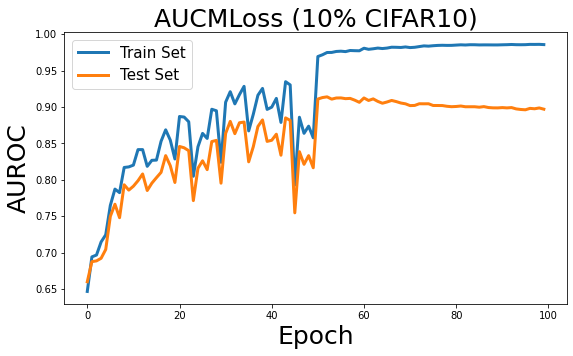

In [48]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(len(train_log))
plt.figure()
plt.plot(x, train_log, LineStyle='-', label='Train Set', linewidth=3)
plt.plot(x, test_log,  LineStyle='-', label='Test Set', linewidth=3)
plt.title('AUCMLoss (10% CIFAR10)',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('AUROC', fontsize=25)
plt.xlabel('Epoch', fontsize=25)